In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

In [2]:
data = pd.read_csv('../data/merged_data.csv', index_col='Date')
data.head()

,Exports,Imports,Trade Balance,Currency in Circulation,Cash with Banks,Currency with the Public,Consumer Goods Manufacture,CPI,GDP,Government Expenditure,Gross Fixed Capital,Immediate Rates,Interest Rates,Share Prices,Wholesale Industry Prices
Date,,,,,,,,,,,,,,,
1996-07-01,2689.0,2937.0,-248.0,129229.0,4250.0,124979.0,17.601184,27.892160,100.834388,3.496083e+11,8.671196e+11,12.026324,11.982626,9.847059,39.379901
1996-10-01,2665.0,3228.0,-563.0,127908.0,4276.0,123632.0,17.368679,28.400053,100.591658,3.605712e+11,8.940429e+11,12.104385,12.112597,3.705483,39.557911
1997-01-01,2941.0,3882.0,-941.0,132945.0,4357.0,128588.0,17.364274,29.060325,100.344831,3.868893e+11,9.379883e+11,11.885136,11.875432,12.452448,40.147988
1997-04-01,2635.0,3180.0,-545.0,143581.0,4411.0,139170.0,17.743765,29.603703,100.109642,3.808070e+11,9.386363e+11,11.042559,11.073390,-2.033017,40.813951
1997-07-01,2988.0,3553.0,-566.0,147880.0,4787.0,143093.0,18.515714,29.455437,99.950991,3.875761e+11,9.518487e+11,10.021937,9.985522,15.788213,40.806259


### View of Predictor Variables Divided by GDP

First, it is useful to visualise the movement of these predictor variables after dividing them by GDP.

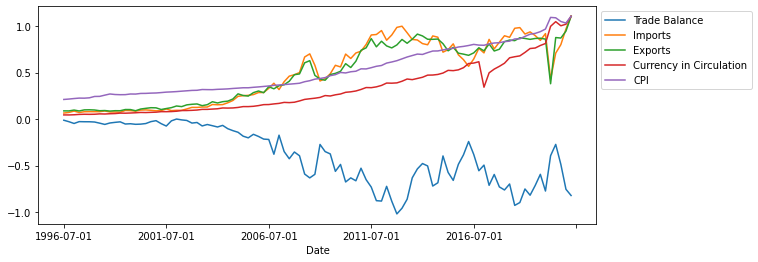

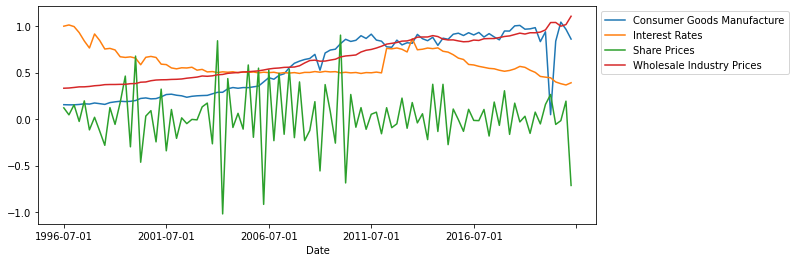

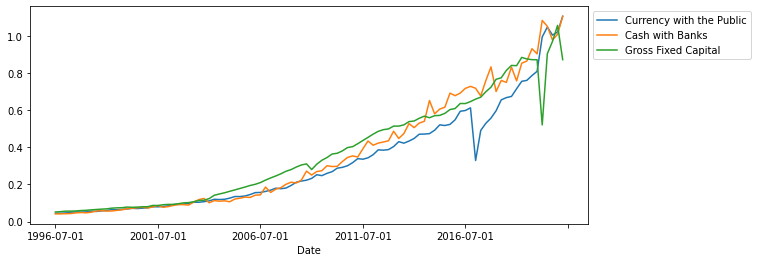

In [3]:
# here we normalize all variables and then divide them by the normalized GDP before plotting
bygdp = data/data.abs().max() 
bygdp = bygdp.div(bygdp.GDP, axis=0)
bygdp[['Trade Balance', 'Imports', 'Exports', 'Currency in Circulation', 'CPI']].plot(figsize=(10,4)).legend(bbox_to_anchor=(1, 1))
bygdp[['Consumer Goods Manufacture', 'Interest Rates', 'Share Prices', 'Wholesale Industry Prices']].plot(figsize=(10,4)).legend(bbox_to_anchor=(1, 1))
bygdp[['Currency with the Public', 'Cash with Banks', 'Gross Fixed Capital']].plot(figsize=(10,4)).legend(bbox_to_anchor=(1, 1))

### Correlation between various variables

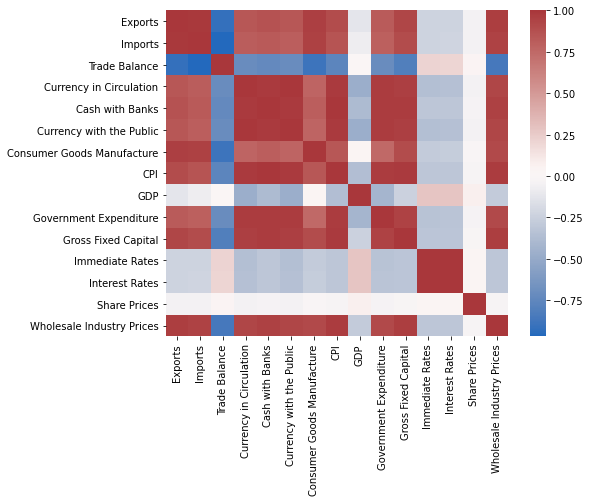

In [4]:
# Displaying correlation coefficients of all variables
corr = data.corr()
plt.figure(figsize=(1.28*6, 6))
sns.heatmap(corr,xticklabels=corr.columns, yticklabels=corr.columns, cmap='vlag')
plt.show()

### Variable trends on the same plot

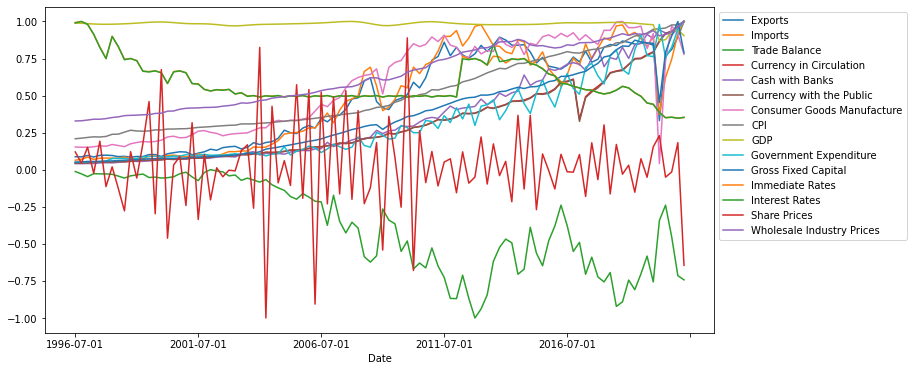

In [5]:
# PLot variation of normalized variables across time on single plot
(data / data.abs().max()).plot(figsize=(12,6)).legend(bbox_to_anchor=(1, 1))
plt.show()

### Primary variable of interest: CPI

> The Consumer Price Index (CPI) is a measure that examines the weighted average of prices of a basket of consumer goods and services, such as transportation, food, and medical care. It is calculated by taking price changes for each item in the predetermined basket of goods and averaging them. Changes in the CPI are used to assess price changes associated with the cost of living

<p style="text-align:right;">
    Source: <a, href="https://www.investopedia.com/terms/c/consumerpriceindex.asp">Investopedia </a>
</p>


CPI is one of the most frequently used statistics for identifying periods of **inflation** or **deflation**. Thus it is a very important economic indicator, and so we have chosen to focus further analysis on CPI and methods to forecast it to predict inflation or deflation

In [6]:
# We saw in the correlation heatmap above that a few variables are almost completely uncorrelated with CPI.
# Let's drop them from consideration

CPI_irrelevant = ['GDP', 'Immediate Rates', 'Interest Rates', 'Share Prices']
data = data.drop(columns=CPI_irrelevant)

In [7]:
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

#### Stationarity Check

Our endgoal is forecasting of CPI. We plan to also try some statistical forecasting models. Statistical forecasting methods work best on stationary data, so we check here if CPI data is stationary, and if not, which of its derivatives makes it stationary.

In [8]:
def check_stationarity(series, d=0):
    "Check stationarity of data."
    #Ho: It is non stationary
    #H1: It is stationary
    series = series.diff(d)[d:] if d!=0 else series
    result = adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary.")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.")
    plt.plot(list(series))
    plt.title(f"Stationarity Check: {d}-Differenced Data")
    plt.show()

ADF Test Statistic : 0.8354748030431243
p-value : 0.9921877451981507
#Lags Used : 11
Number of Observations Used : 88
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


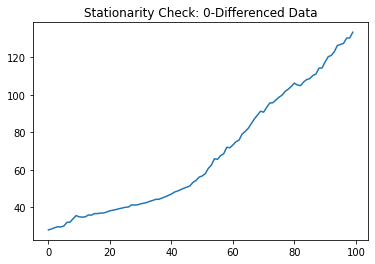

In [9]:
check_stationarity(data.CPI, d=0) # original data

ADF Test Statistic : -1.130572489097116
p-value : 0.7027272724868867
#Lags Used : 10
Number of Observations Used : 88
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


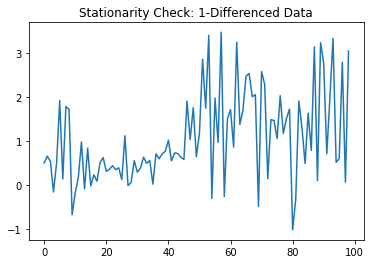

In [10]:
check_stationarity(data.CPI, d=1) # 1st derivative

Even after checking for further increments in d, it seems that this data can not be made stationary. Nevertheless, we still pursue a statistical model as a baseline.

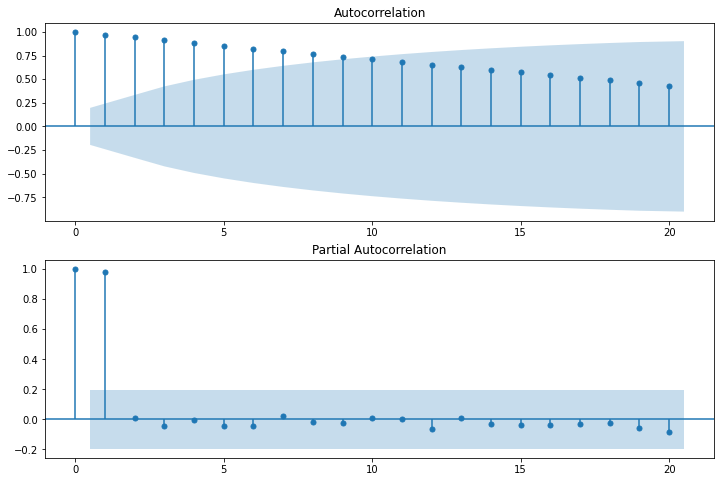

In [11]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.CPI,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.CPI,ax=ax2)

plt.show()

Thus CPI's correlation with lags of itself seems to be monotonically decreasing. The partial autocorrelation plot further shows that previous lag captures all important information, so further lags are redundant for forming historical trend / seasonal features

In [12]:
# some features are commented out because we saw in our analysis that lag 1 captures enough information,
# so further lags are redundant, and consequently the rolling means

def get_seasonal_and_trend_features(data, feature, keep_orig=False, norm=True):
    df = data[[feature]] if keep_orig else pd.DataFrame()
    df[f'{feature}_lag_1'] = data[feature].shift(1)
    # df[f'{feature}_lag'] = data[feature].shift(2)
    # df[f'{feature}_lag'] = data[feature].shift(3)
    # df[f'{feature}_rolling_mean_2'] = data[feature].rolling(2).mean()
    # df[f'{feature}_rolling_mean_3'] = data[feature].rolling(3).mean()
    # df[f'{feature}_rolling_mean_4'] = data[feature].rolling(4).mean()
    df[f'{feature}_slope_1'] = data[feature].diff(1)
    # df[f'{feature}_slope_2'] = data[feature].diff(2)/2
    # df[f'{feature}_slope_3'] = data[feature].diff(3)/3
    
    df = (df / df.abs().max()) if norm else df #normalize
    return df

feature_df = get_seasonal_and_trend_features(data, 'CPI', keep_orig=True, norm=False)
feature_df.head()

,CPI,CPI_lag_1,CPI_slope_1
Date,,,
1996-07-01,27.892160,NaN,NaN
1996-10-01,28.400053,27.892160,0.507893
1997-01-01,29.060325,28.400053,0.660272
1997-04-01,29.603703,29.060325,0.543378
1997-07-01,29.455437,29.603703,-0.148266


In [13]:
def cross_corr(a, b, lags=6):
    res = []
    for i in range(0,lags+1):
        res.append(a.corr(b.shift(i)))
    return np.array(res)

def exog_feature_corr(df, feature, color=None):
    corr_vals = cross_corr(df[feature], df.CPI)
    plt.bar(np.arange(len(corr_vals)), corr_vals , color=color)
    plt.title(f"Cross-correlation of CPI with {feature}")
    plt.xlabel("Lag")
    plt.ylabel("Correlation Value")
    plt.show()
    return corr_vals

In [14]:
exog_features = list(data.columns)
exog_features.remove('CPI')

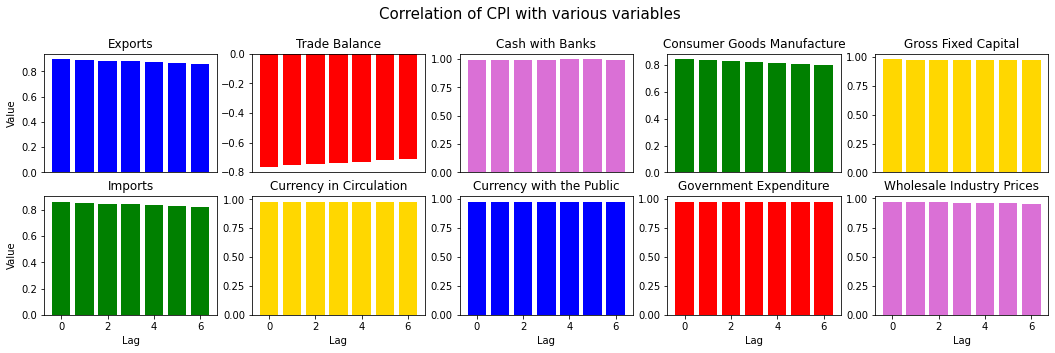

In [15]:
colors = ['blue', 'green', 'red', 'gold', 'orchid']
colors = cycle(colors)

fig, axs = plt.subplots(2, 5, figsize=(18,5))
plt.suptitle('Correlation of CPI with various variables', fontsize=15)

for i in range(5):
    for j in range(2):
        feature = exog_features[i*2+j]
        corr_vals = cross_corr(data[feature], data.CPI)
        axs[j, i].bar(np.arange(len(corr_vals)), corr_vals, color=next(colors))
        axs[j, i].set_title(f"{feature}")
        if j==1: axs[j, i].set_xlabel("Lag")
        else: axs[j,i].xaxis.set_visible(False)
        if i==0: axs[j, i].set_ylabel("Value")

            
plt.subplots_adjust(top=0.85)
plt.show()

Thus we see that for all exogenous variables, absolute values of cross-correlation between CPI and lags of exogenous variables remain almost the same, marginally decreasing as lag increases. Thus, we will repeat our choice in the case of CPI, and will consider 1 lag of exogenous variable, along with 3 trend / slope features for each exogenous variable.

### Generate features for forecasting

In [16]:
for feature in exog_features:
    feature_df = pd.merge(feature_df, get_seasonal_and_trend_features(data, feature),
                          left_index=True, right_index=True, how='inner')
    
feature_df = feature_df.dropna()

In [17]:
# new feature data details
print(f'No. of Features = {len(feature_df.columns) -1}')
print(f'No. of usable data points = {len(feature_df)}')
feature_df.columns

No. of Features = 22
No. of usable data points = 99


Index(['CPI', 'CPI_lag_1', 'CPI_slope_1', 'Exports_lag_1', 'Exports_slope_1',
       'Imports_lag_1', 'Imports_slope_1', 'Trade Balance_lag_1',
       'Trade Balance_slope_1', 'Currency in Circulation_lag_1',
       'Currency in Circulation_slope_1', 'Cash with Banks_lag_1',
       'Cash with Banks_slope_1', 'Currency with the Public_lag_1',
       'Currency with the Public_slope_1', 'Consumer Goods Manufacture_lag_1',
       'Consumer Goods Manufacture_slope_1', 'Government Expenditure_lag_1',
       'Government Expenditure_slope_1', 'Gross Fixed Capital_lag_1',
       'Gross Fixed Capital_slope_1', 'Wholesale Industry Prices_lag_1',
       'Wholesale Industry Prices_slope_1'],
      dtype='object')

In [18]:
# save feature data
feature_df.to_csv('../data/features.csv')